Import Modules


In [3]:
# modules
%reload_ext tensorboard
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as K

In [4]:
# install GPy and GPyOpt
!pip install GPy
!pip install GPyOpt

In [5]:
# import GPy Module
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

LOAD DATASET

In [6]:
# setting the train and test data 
# datasets = mnist.load_data()
datasets = np.load('../content/MNIST.npz')
X_train = datasets['X_train']
X_train = X_train.reshape(X_train.shape[0], -1)
Y_train = datasets['Y_train']
X_valid = datasets['X_valid']
X_valid = X_valid.reshape(X_valid.shape[0], -1)
Y_valid = datasets['Y_valid']

print("Size of:")
print("- Training-set:\t\t{}".format(X_train.shape))
print("- Validation-set:\t{}".format(X_valid.shape))

Size of:
- Training-set:		(50000, 784)
- Validation-set:	(10000, 784)


ONE HOT FUNCTION

In [7]:
def one_hot(labels, classes=None):
    """
    that converts a label vector into a one-hot matrix:

    The last dimension of the one-hot matrix must be the number of classes
    Returns: the one-hot matrix
    """
    one_hot = K.utils.to_categorical(y=labels, num_classes=classes)
    return one_hot

In [8]:
Y_train_oh = one_hot(Y_train)
Y_valid_oh = one_hot(Y_valid)

print("Size of:")
print("- Training-set:\t\t{}".format(Y_train.shape))
print("- Validation-set:\t{}".format(Y_valid.shape))

Size of:
- Training-set:		(50000,)
- Validation-set:	(10000,)


MODEL STRUCTURE

In [9]:
def build_model(nx, layers, activations, lambtha, keep_prob):
    """
    * nx is the number of input features to the network
    * layers is a list containing the number of nodes in each layer of the
        network
    * activations is a list containing the activation functions used for each
        layer of the network
    * lambtha is the L2 regularization parameter
    * keep_prob is the probability that a node will be kept for dropout
    * You are not allowed to use the Input class
    * Returns: the keras model
    """
    reg = K.regularizers.l2(lambtha)

    X = K.Input(shape=(nx,))
    layer_l2 = K.layers.Dense(units=layers[0], activation=activations[0],
                              kernel_regularizer=reg)
    Y_prev = layer_l2(X)

    for i in range(1, len(layers)):

        layer_drop = K.layers.Dropout(1 - keep_prob)
        Y = layer_drop(Y_prev)

        layer_l2 = K.layers.Dense(units=layers[i], activation=activations[i],
                                  kernel_regularizer=reg)
        Y_prev = layer_l2(Y)

    Y_pred = Y_prev
    model = K.Model(inputs=X, outputs=Y_pred)
    return model

MODEL OPTIMIZER

In [10]:
def optimize_model(network, alpha, beta1, beta2):
    """
    * that sets up Adam optimization for a keras model with
         categorical crossentropy loss and accuracy metrics:
    * network is the model to optimize
    * alpha is the learning rate
    * beta1 is the first Adam optimization parameter
    * beta2 is the second Adam optimization parameter
    Returns: None
    """
    Adam = K.optimizers.Adam(lr=alpha, beta_1=beta1, beta_2=beta2)
    network.compile(loss='categorical_crossentropy', optimizer=Adam,
                    metrics=['accuracy'])
    return None

In [11]:
def train_model(network, data, labels, batch_size, epochs,
                validation_data=None, early_stopping=False, patience=0,
                learning_rate_decay=False, alpha=0.1, decay_rate=1,
                save_best=False, filepath=None, verbose=True, shuffle=False):
    """
    * network is the model to train
    * data is a numpy.ndarray of shape (m, nx) containing the input data
    * labels is a one-hot numpy.ndarray of shape (m, classes) containing
            the labels of data
    * batch_size is the size of the batch used for mini-batch gradient descent
    * epochs is the number of passes through data for mini-batch
             gradient descent
    * verbose is a boolean that determines if output should be printed during
            training
    * shuffle is a boolean that determines whether to shuffle the batches every
          epoch. Normally, it is a good idea to shuffle, but for
          reproducibility we have chosen to set the default to False.
    * early_stopping is a boolean that indicates whether early stopping
          should be used
          early stopping should only be performed if validation_data exists
          early stopping should be based on validation loss
    * patience is the patience used for early stopping
    * learning_rate_decay is a boolean that indicates whether learning rate
          decay should be used
      learning rate decay should only be performed if validation_data exists
      the decay should be performed using inverse time decay
      the learning rate should decay in a stepwise fashion after each epoch
    * each time the learning rate updates, Keras should print a message
           alpha is the initial learning rate
           decay_rate is the decay rate
    * save_best is a boolean indicating whether to save the model after each
           epoch if it is the best
    * a model is considered the best if its validation loss is the lowest that
           the model has obtained
    * filepath is the file path where the model should be saved
    Returns: the History object generated after training the model
    """

    def learning_decay(epoch):
        """
        funcion in the learningRateSchedule
        the alpha doesnt change
        """
        return alpha / (1 + decay_rate * (epoch / 1))

    my_list = []
    if early_stopping is True and validation_data:
        early = K.callbacks.EarlyStopping(patience=patience)
        my_list.append(early)

    if learning_rate_decay is True and validation_data:
        learn_dec = K.callbacks.LearningRateScheduler(learning_decay,
                                                      verbose=1)
        my_list.append(learn_dec)

    if save_best is True and validation_data:
        save = K.callbacks.ModelCheckpoint(filepath=filepath,
                                           save_best_only=True)
        my_list.append(save)

    if len(my_list) == 0:
        my_list = None

    history = network.fit(x=data, y=labels, batch_size=batch_size,
                          epochs=epochs, verbose=verbose, shuffle=shuffle,
                          validation_data=validation_data, callbacks=my_list)
    
    return history


FUNCTIONS DEFINITIONS


In [12]:
best_accuracy = 0

def F(l2, lr, drop, unit, bch_size):
    print('Input', l2, lr, drop, unit, bch_size)
    lambtha = l2
    keep_prob = drop
    network = build_model(784, [int(unit), int(unit), 10], ['relu', 'relu', 'softmax'], lambtha, keep_prob)
    alpha = lr
    beta1 = 0.9
    beta2 = 0.999
    optimize_model(network, alpha, beta1, beta2)
    batch_size = int(bch_size)
    epochs = 5
    
    filepath = 'model_lambda{}_keepprob{}_batch{}_units{}_learningr{}.h5'.format(lambtha, keep_prob, batch_size, int(unit), lr)

    history = train_model(network, X_train, Y_train_oh, batch_size, epochs,
                          validation_data=(X_valid, Y_valid_oh), early_stopping=True,
                          patience=3, learning_rate_decay=True, alpha=alpha,
                          save_best=True, filepath=filepath)
   

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    global best_accuracy
    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    
    print(accuracy, best_accuracy)
    path_best_model='best.h5'

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        network.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del network

    tf.keras.backend.clear_session()
    
    return accuracy


def f(X):
  Y = np.zeros((X.shape[0], 1))
  for i in range(X.shape[0]):
    Y[i] = F(X[i][0], X[i][1], X[i][2], X[i][3], X[i][4])
    
  return(Y)

In [14]:

X_init = np.array([[0.001, 0.0001, 0.015, 448, 128], [0.00809, 0.00624, 0.42, 500, 16]])
Y_init = f(X_init)

Input 0.001 0.0001 0.015 448.0 128.0

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/5
391/391 [==============================] - 6s 16ms/step - loss: 7.2735 - accuracy: 0.0957 - val_loss: 2.8966 - val_accuracy: 0.1149

Epoch 00002: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 2/5
391/391 [==============================] - 6s 15ms/step - loss: 3.2575 - accuracy: 0.0993 - val_loss: 2.8436 - val_accuracy: 0.1084

Epoch 00003: LearningRateScheduler reducing learning rate to 3.3333333333333335e-05.
Epoch 3/5
391/391 [==============================] - 6s 15ms/step - loss: 3.0467 - accuracy: 0.1029 - val_loss: 2.8246 - val_accuracy: 0.1083

Epoch 00004: LearningRateScheduler reducing learning rate to 2.5e-05.
Epoch 4/5
391/391 [==============================] - 6s 15ms/step - loss: 2.9570 - accuracy: 0.1043 - val_loss: 2.8149 - val_accuracy: 0.1068

Epoch 00005: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 5/5
391/391 [===========

In [15]:
print(Y_init)

[[0.1067    ]
 [0.89109999]]


Input 0.009769954830299452 0.008494288476183016 0.06158158082087262 64.0 128.0

Epoch 00001: LearningRateScheduler reducing learning rate to 0.008494288476183016.
Epoch 1/5
391/391 [==============================] - 1s 4ms/step - loss: 2.4628 - accuracy: 0.1130 - val_loss: 2.3035 - val_accuracy: 0.1064

Epoch 00002: LearningRateScheduler reducing learning rate to 0.004247144238091508.
Epoch 2/5
391/391 [==============================] - 1s 3ms/step - loss: 2.3019 - accuracy: 0.1136 - val_loss: 2.3019 - val_accuracy: 0.1064

Epoch 00003: LearningRateScheduler reducing learning rate to 0.002831429492061005.
Epoch 3/5
391/391 [==============================] - 1s 3ms/step - loss: 2.3013 - accuracy: 0.1136 - val_loss: 2.3018 - val_accuracy: 0.1064

Epoch 00004: LearningRateScheduler reducing learning rate to 0.002123572119045754.
Epoch 4/5
391/391 [==============================] - 1s 3ms/step - loss: 2.3012 - accuracy: 0.1136 - val_loss: 2.3019 - val_accuracy: 0.1064

Epoch 00005: Learnin

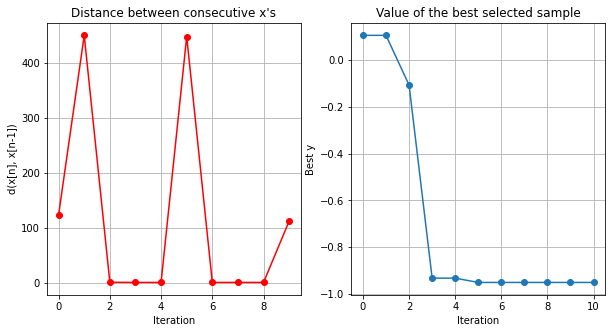

In [26]:
# kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0)
bds = [{'name': 'l2', 'type': 'continuous', 'domain': (0.00001, 0.01)},
       {'name': 'lr', 'type': 'continuous', 'domain': (0.00001, 0.01)}, # added 1 0 at min
       {'name': 'drop', 'type': 'continuous', 'domain': (0, 0.5)},
       {'name': 'unit', 'type': 'discrete', 'domain': (64, 512)},
       {'name': 'bch_size', 'type': 'discrete', 'domain': (16, 128)}]

optimizer = BayesianOptimization(f=f, 
                                 domain=bds,
                                 model_type='GP',
                                 #kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 X=X_init,
                                 Y=Y_init,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True,
                                 report_file='bayes_opt.txt')


optimizer.run_optimization(max_iter=9)
optimizer.plot_acquisition()
optimizer.plot_convergence()